In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import scipy.optimize
import sklearn.linear_model

In [2]:
def load_pvgis_csv(path, timezone):
    with open(path, "r") as csv_file:
        header_line_index = None
        empty_line_index = None
        for i, line in enumerate(csv_file):
            if header_line_index is None:
                if line.strip() == "time,P,G(i),H_sun,T2m,WS10m,Int":
                    header_line_index = i
            elif not line.strip():
                empty_line_index = i
                break
        if header_line_index is None or empty_line_index is None:
            raise ValueError("header or footer not found in solar CSV")

    solar_df = pd.read_csv(
        path,
        skiprows=header_line_index,
        nrows=empty_line_index - header_line_index - 1,
    )

    solar_df = pd.DataFrame(
        {
            "irradiance": solar_df["G(i)"].values,
            "system_power": solar_df["P"].values,
        },
        index=pd.DatetimeIndex(
            pd.to_datetime(solar_df["time"], format="%Y%m%d:%H%M", utc=True).rename(
                None
            )
        ).tz_convert(timezone).tz_localize(None), # Naive local time
    )

    return solar_df

pvgis_df = load_pvgis_csv('../data/pvgis_2016_horw.csv', 'Europe/Zurich')

In [3]:
duplicates = pvgis_df.index.duplicated()
print(f'Dropping {duplicates.sum()} duplicates')
pvgis_df = pvgis_df[~duplicates]

Dropping 1 duplicates


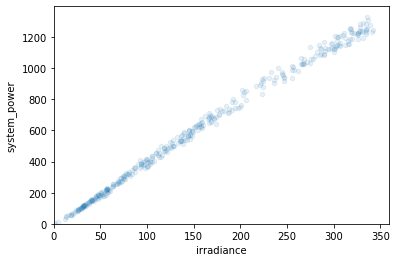

In [4]:
pvgis_df.resample('1D').mean().plot.scatter('irradiance', 'system_power', alpha=0.1, xlim=(0, None), ylim=(0, None));

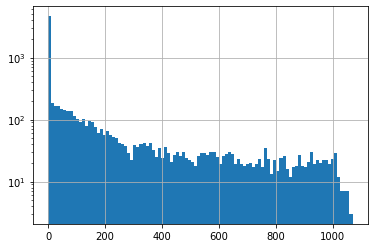

In [5]:
pvgis_df.irradiance.hist(bins=100, log=True);

In [6]:
ihl_df = pd.read_hdf('../data/published_data_vs01/data/dfC_300s.hdf')

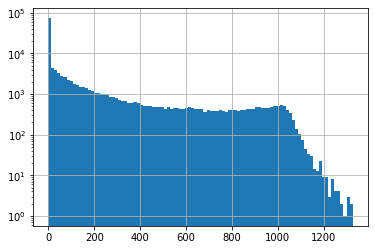

In [7]:
ihl_df['C_solarlog_radiation'].hist(bins=100, log=True);

In [8]:
temp = ihl_df['C_solarlog_radiation'].dropna().index
overlap_range = (
    max(pvgis_df.index.min(), temp.min()),
    min(pvgis_df.index.max(), temp.max()),
)
overlap_range

(Timestamp('2016-02-26 17:30:00'), Timestamp('2017-01-01 00:10:00'))

In [9]:
overlap_df = pd.DataFrame({
    'ihl_radiation': ihl_df['C_solarlog_radiation'].dropna(),
    'pvgis_radiation': pvgis_df.irradiance.dropna().asfreq('5T'),
})
overlap_df = overlap_df[overlap_range[0]:overlap_range[1]]
overlap_df.describe()

,ihl_radiation,pvgis_radiation
count,89073.000000,7422.000000
mean,160.790747,168.716886
std,274.182195,272.303632
min,0.000000,0.000000
25%,0.000000,0.000000
50%,5.000000,3.940000
75%,192.333333,220.690000
max,1325.500000,1070.150000


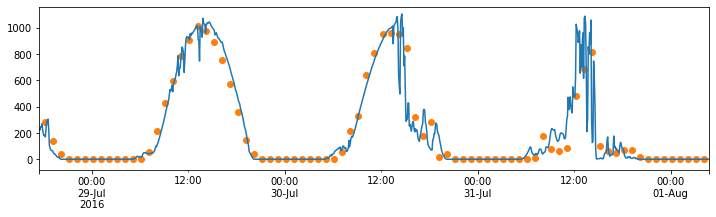

In [15]:
def random_window(df, window_length):
    i = random.randrange(len(df) - window_length)
    return df.iloc[i:i + window_length]

fig, ax = plt.subplots(figsize=(12, 3))
sample_df = random_window(overlap_df, 1000)
sample_df.ihl_radiation.plot(ax=ax)
ax.scatter(sample_df.index, sample_df.pvgis_radiation, c='C1');